In [9]:
import cv2 as cv
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
#from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle

import importlib
import copy

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
import featexlib
from featexlib import Debug as dbug
from featexlib import *

tf.compat.v1.enable_eager_execution()

In [10]:
##Load scaler
scaler = pickle.load(open('../../models/scalers/billid_256x256_unet_scaler_v_test_1.pkl','rb'))
#scaler_feat = pickle.load(open('../../models/scalers/dig4_256f_e5_cl2000_acc100_on_1000.pkl','rb')) 

In [11]:
###Loading models

###Prepare model
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet(pretrained_weights ='../../models/billid_256x256_unet_acc09852')
#rand = np.random.rand(1,256,256,1).astype("float32")
#res = model(rand)
#del res, rand

In [5]:
###NOT USED
###Model parameters
pic_h = 32
pic_w = 84
num_feat = 256
num_classes = 2000

###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        ###Num features is 'num_feat'
        ###Num classes is 'num_classes'
        
        #Input pixel numbers is pic_h*pic_w*1
        input_shape = (-1,pic_h,pic_w,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC*num_feat - feature vector
        #11: FC*num_classes - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init) #, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01)
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init) #, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01)
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(num_feat, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(num_classes)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(np.zeros([num_classes,num_feat], dtype=np.float64), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,pic_h,pic_w,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        #tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        #tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        #tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        #tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, num_classes)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self, name, save_dir = "models"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_weights(os.path.join(save_dir, name))

    def load_model(self, name, load_dir = "models"):
        self.load_weights(os.path.join(load_dir, name))
        
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss

#Helpful function to control center loss during training    
def center_loss_progress(n_prog,n_iter, koeff, n_init = 0):
    return koeff*(n_prog+1)/(n_iter) if n_prog<n_iter else koeff   

model_feat = Model(0.005, dropout_rate = 0.15, variance_epsilon=1e-3)
model_feat_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()
model_feat.compile(opt, loss=model_feat_loss, metrics=["accuracy"])
model_feat.load_model("dig4_256f_e5_cl2000_acc100_on_1000", load_dir = "../../models")

rand = np.random.rand(1,32,84).astype("float32")
res1, res2 = model_feat(rand)
del res1, res2, rand

In [5]:
####Small test pipilene
importlib.reload(featexlib)

###read images
test_images = Image_generator.load_from_folder("../../Data/4dig/test")
result_list = []
result_txt = []
cut_list = []

for img in test_images:
    ###read img
    #img_inp = cv.imread('Data/4dig/test/WIN_20200621_10_45_54_Pro.jpg', cv.IMREAD_UNCHANGED) 
    img_inp = img
    ###Cut image
    t,l,h,w = 0,img_inp.shape[1]-256,(img_inp.shape[0]-70),(img_inp.shape[0]-70)
    img_inp = img_inp[t:t+h,l:l+w]
    #img_inp = test_image
    ###Convert to gray and resize
    img_gray = cv.cvtColor(img_inp, cv.COLOR_BGR2GRAY)
    img_gray = cv.resize(img_gray, (256,256), interpolation = cv.INTER_AREA) 
    ###Get inversion
    img_gray_inv = (255-img_gray)
    #Normalise image
    #mean, STD  = cv.meanStdDev(img_gray_inv)
    offset_pos = 3
    offset_neg = 3
    #img_gray = np.clip(img_gray_inv, mean - offset_neg*STD, mean + offset_pos*STD) 
    #print("Before normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    #img_gray_inv = cv.normalize(img_gray_inv, img_gray_inv, 0, 255, norm_type=cv.NORM_MINMAX)
    #print("After normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    ###Show prepared image
    ###dbug.Debug.show_image(img[:,:,[2,1,0]]) #for PIL format
    #dbug.Debug.show_image(img_gray_inv.reshape(pic_h,pic_w))
    ###rescale for NN
    img_gray_inv_scaled  = scaler.transform(img_gray_inv.reshape(-1,256*256)).astype('float32')
    ###Make prediction
    predict = model(img_gray_inv_scaled.reshape(-1,256,256,1)).numpy()
    predict_tresh = cv.threshold(predict.reshape(256,256), 0.5, 1, cv.THRESH_BINARY)[1].astype('uint8')
    ###Find contours
    contours, hierarchy = cv.findContours(predict_tresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    result = predict.reshape(256,256)*255
    bb_list = [cv.boundingRect(contour) for contour in contours]
    if(bb_list):
        #bb = max(bb_list, key=lambda item: item[2])
        mp_find = []
        for bb in bb_list:
            cen_w = (bb[0]+bb[2]/2)
            cen_h = (bb[1]+bb[3]/2)
            mp_find.append((np.sqrt((128-cen_h)**2+(128-cen_w)**2) - 128)*1 + 1*(2688/(bb[2]*bb[3])))
        #result = cv.drawContours(result, contours[0], -1, 255, 3)
        bb = bb_list[np.argmin(mp_find)]
        cw = int((bb[0]+bb[2]/2))
        ch = int((bb[1]+bb[3]/2))
        half_size = int(np.max([bb[2],bb[3]])/2)
        pad_h = 2
        pad_w = 2
        boards = np.clip([ch-half_size-pad_h, cw-half_size-pad_w, ch+half_size+pad_h, cw+half_size+pad_w], 0, 255) 
        t,l,b,r = boards[0],boards[1],boards[2],boards[3]
        #print(t,l,b,r)
        cut_img = img_gray_inv[t:b,l:r]
        cut_resized = cv.resize(cut_img, (84,84), interpolation = cv.INTER_AREA)[26:26+32,:] 
        cut_list.append(cut_resized)
        result = cv.rectangle(img_gray, (bb[0], bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), 255, 4)
        
    result_list.append(result)
    result_txt.append("|".join([str(i)[0:5] for i in mp_find]))

cut_list = np.array(cut_list)    
    
###Show result
dbug.Debug.show_images_list(result_list,result_txt, col_number = 2, height=5)

NameError: name 'mp_find' is not defined

In [6]:
cut_list_rescaled = scaler_feat.transform(cut_list.reshape(cut_list.shape[0],-1)).astype('float32')

AttributeError: 'list' object has no attribute 'reshape'

In [7]:
y_pred_logits, features_tf = model_feat(cut_list_rescaled)

NameError: name 'cut_list_rescaled' is not defined

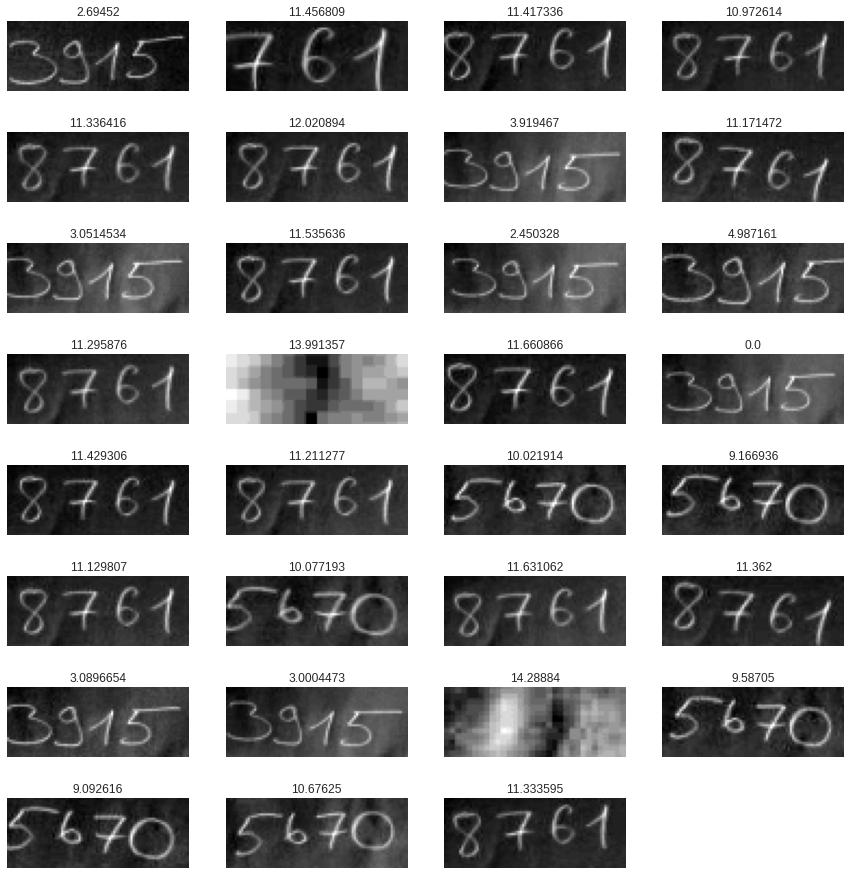

In [13]:
res_dist = []
for feat in features_tf:
    res_dist.append(np.linalg.norm(feat - features_tf[15]))
    
dbug.Debug.show_images_list(cut_list,res_dist, col_number = 4, height=2)

In [12]:
######CLASS ORIGIN IS HERE NOW 15.07.2021 #################

class Feature_detection(object):
    def __init__(self, feature_shape, buff_len = 5, center_norm_lim=0.5, center_dist_norm_lim=0.5, likeness_lim = 0.5):
        self.id_list = np.array([])
        self.ft_shape = feature_shape
        self.buff_len = buff_len
        self.ft_buffer = np.zeros( (buff_len, ) + feature_shape , dtype='float32') 
        self.center_norm_lim = center_norm_lim
        self.center_dist_norm_lim = center_dist_norm_lim
        self.likeness_lim = likeness_lim

    def add_to_buffer(self, inp):
        self.ft_buffer = np.vstack([np.delete(self.ft_buffer, 0, 0),inp])

        
    def get_vector_from_buffer(self):
        
        center = np.mean(self.ft_buffer, axis=0)
        center_norm = np.linalg.norm(center)
        center_dist = self.ft_buffer-center
        center_dist_norm = np.linalg.norm(center_dist, axis=1)
        print("center_dist_norm.max()",center_dist_norm.max())
        print("center_norm",center_norm)
        if center_norm>self.center_norm_lim and center_dist_norm.max()<self.center_dist_norm_lim:
            return center
        return None
        
    def get_id(self, inp):  
        inp = inp[None,...]
        if len(self.id_list) > 0:
            likeness_dist_norm_arr = np.linalg.norm(self.id_list - inp, axis=1)
            likeness_dist_norm_min = likeness_dist_norm_arr.min()
            likeness_indice = likeness_dist_norm_arr.argmin()
            print("likeness_dist_norm_min",likeness_dist_norm_min)
            if likeness_dist_norm_min < self.likeness_lim:
                return likeness_indice+1
            else:
                self.id_list = np.vstack([self.id_list,inp])
                return len(self.id_list)
        else:
            self.id_list = inp
            return len(self.id_list)
        
    def __call__(self, inp):
        
        if inp is None:
            inp = np.zeros(self.ft_shape)
        inp = np.array(inp)
        
        self.add_to_buffer(inp)
        
        vector = self.get_vector_from_buffer();
        
        if vector is not None:
            inp_id = self.get_id(inp)
        else:
            inp_id = None
        
        return inp_id
        


In [13]:
####Production class 
######CLASS ORIGIN IS HERE NOW 15.07.2021 #################

class Production(object):
    def __init__(self, pipeline):
        self.pipeline = pipeline
    
    def __call__(self, inp_data):
        return self.pipeline(inp_data)
    
    class Pipeline_base(object):
        def __init__(self, proc_layers, inp_channel = 1, out_channels = (1)):
            self.proc_layers = proc_layers
            self.inp_channel = inp_channel
            self.out_channels = out_channels
        
    class Pipeline_model_feat(Pipeline_base):
        def __init__(self, proc_layers, inp_channel = 1, out_channels = (1)):
            super().__init__(proc_layers, inp_channel = inp_channel, out_channels = out_channels)
        
        def __call__(self, inp_data):
            #Initialize inter layer object
            out_channels_process_data = {self.inp_channel:Production.Process_data(inp_data, info={})}
            
            for proc_layer in self.proc_layers:
                out_channels_process_data = proc_layer(out_channels_process_data)
            
            #return output channel
            return  [out_channels_process_data[i] for i in self.out_channels]
    
    class Layer(object):
        def __init__(self, inp_channel = 1, out_channel = 1):
            self.proc_data = {}
            self.ic = inp_channel
            self.oc = out_channel
            
        def __call__(self, channels_process_data):
            if self.oc == self.ic:
                channels_process_data[self.oc] = self.calc(channels_process_data[self.ic])
            else:
                channels_process_data[self.oc] =  self.calc(copy.deepcopy(channels_process_data[self.ic]))
            return channels_process_data
        
        ###Calc should be overwritten in subclass
        def calc(self, process_data):
            return process_data   

    class Layer_2_inputs(Layer):
        def __init__(self, inp_channel_1 = 1, inp_channel_2 = 2, out_channel = 1):
            self.ic = (inp_channel_1, inp_channel_2)
            self.oc = out_channel

        def __call__(self, channels_process_data):
            if any(list(map(lambda x: x==self.oc,self.ic))):
                channels_process_data[self.oc] = self.calc(channels_process_data[self.ic[0]],channels_process_data[self.ic[1]])
            else:
                channels_process_data[self.oc] =  self.calc(copy.deepcopy(channels_process_data[self.ic[0]]),copy.deepcopy(channels_process_data[self.ic[1]]))
            return channels_process_data
        
        ###Calc should be overwritten in subclass
        def calc(self, process_data):
            return process_data   
        
    ###Process layer: Cut part of image
    class Layer_cut(Layer):
        def __init__(self, t,l,h,w, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.t, self.l, self.h, self.w = t,l,h,w
            
        def calc(self, process_data):
            inp_img = process_data.data
            
            #Check limits
            t = self.t if self.t<=inp_img.shape[0] else inp_img.shape[0]
            l = self.l if self.l<=inp_img.shape[1] else inp_img.shape[1]
            b = self.t+self.h if (self.t+self.h)<=inp_img.shape[0] else inp_img.shape[0]
            r = self.l+self.w if (self.l+self.w)<=inp_img.shape[1] else inp_img.shape[1]
            
            #Cut image
            out_img = inp_img[t:b,l:r,...]
            
            #Store data
            process_data.data = out_img
            
            process_data.info["transform_chain"].append(("cut",(t,l,b,r)))
            
            return process_data

    ###Process layer: Input image
    class Layer_input(Layer):
        def __init__(self, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            
        def calc(self, process_data):
            inp_img = np.array(process_data.data)
            
            #Check inp shape (AxB) or (AxBxC)
            if((inp_img.ndim > 3) or (inp_img.ndim < 2)):
                raise ValueError("Wrong image dimension")
            
            #Reshape (AxB)->(AxBx1)
            if (inp_img.ndim==2):
                inp_img = inp_img[...,None]
            
            #Add info and data
            process_data.data = inp_img
            process_data.info["transform_chain"] = []
            process_data.info["inp_shape"] = inp_img.shape
            return process_data
        
    ###Process layer: Convert to gray
    class Layer_to_gray(Layer):
        def __init__(self, rgb_weights = [0.2989, 0.5870, 0.1140], invert = False, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.rgb_weights = rgb_weights
            self.invert = invert
            
        def calc(self, process_data):
            if 'fail' in process_data.info:
                return process_data
            process_data.data = (255-np.dot(process_data.data[...,:3], self.rgb_weights) if self.invert else np.dot(process_data.data[...,:3], self.rgb_weights))[...,None].astype(np.uint8)
            return process_data  

    ###Process layer: Convert gray to R or G or B
    class Layer_to_rgb(Layer):
        def __init__(self, mode = "r", inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.mode = mode
            
        def calc(self, process_data):
            out_shape = list(process_data.data.shape)
            out_shape[-1] = 2
            
            out = np.concatenate((process_data.data, np.zeros(out_shape,dtype=np.uint8)), axis=2)
            if self.mode == "b":
                process_data.data = out
            if self.mode == "g":
                process_data.data = out[...,[1,0,2]]
            if self.mode == "r":
                process_data.data = out[...,[1,2,0]]
            
            process_data.info["color"] = self.mode
            
            return process_data  

    ###Process layer: resize
    class Layer_resize(Layer):
        def __init__(self, w, h, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.w, self.h = w, h
            
        def calc(self, process_data):
            process_data.info["transform_chain"].append(("resize",(process_data.data.shape[1]/self.w,process_data.data.shape[0]/self.h)))
            process_data.data = cv.resize(process_data.data, (self.w,self.h), interpolation = cv.INTER_AREA) 
            return process_data 
        
    ###Process layer: scaler
    class Layer_scaler(Layer):
        def __init__(self, file="", inp_channel = 1, out_channel = 1 , astype=None):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.scaler = pickle.load(open(file,'rb'))
            self.astype = astype
            
        def calc(self, process_data):
            
            if 'fail' in process_data.info:
                return process_data
            
            inp_shape = process_data.data.shape
            process_data.data = (self.scaler.transform(process_data.data.reshape(-1,np.prod(inp_shape)))).reshape(inp_shape)

            if self.astype is not None:
                process_data.data = process_data.data.astype(self.astype)
            return process_data 
        
    ###Process layer: model
    class Layer_model(Layer):
        def __init__(self, model, input_shape, output_shape=None, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.model = model
            self.input_shape = input_shape
            self.output_shape = output_shape
            
        def calc(self, process_data):
            
            if 'fail' in process_data.info:
                return process_data
            
            result = self.model(process_data.data.reshape(self.input_shape)).numpy()
            
            if self.output_shape is not None:
                result = result.reshape(self.output_shape)
            else:
                result = result.reshape(self.input_shape[1:])
                
            process_data.data = result
            return process_data
        
    ###Process layer: model for feature extraction
    class Layer_model_feature(Layer):
        def __init__(self, model, input_shape, output_shape=None, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.model = model
            self.input_shape = input_shape
            self.output_shape = output_shape
            
        def calc(self, process_data):
            if 'fail' in process_data.info:
                return process_data
            
            _, features = self.model(process_data.data.reshape(self.input_shape))
            
            if self.output_shape is not None:
                result = features.numpy().reshape(self.output_shape)
            else:
                result = features.numpy().reshape(self.input_shape[1:])
                
            process_data.data = result
            return process_data
        
    ###Process layer: normalize (-STD*k|<--mean(+/-)-->|STD*k)->Normalize
    class Layer_normalize(Layer):
        def __init__(self, mean_shift=0, std_offset_pos=1, std_offset_neg=1, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            
            self.mean_shift, self.std_offset_pos, self.std_offset_neg = mean_shift, std_offset_pos, std_offset_neg
            
        def calc(self, process_data):
            mean, STD  = cv.meanStdDev(process_data.data)
            process_data.data = np.clip(process_data.data + (mean*self.mean_shift), mean*(1+self.mean_shift) - self.std_offset_neg*STD, mean*(1+self.mean_shift) + self.std_offset_pos*STD )# 
            process_data.data = np.clip(process_data.data, 0, 255)
            process_data.data = cv.normalize(process_data.data, None, 0, 255, norm_type=cv.NORM_MINMAX)
            return process_data
    
    ###Process layer: treshold
    class Layer_treshold(Layer):
        def __init__(self, ll=0.5, lh=1.0, info_id = 1, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.ll = ll
            self.lh = lh
            self.info_id = info_id
            
        def calc(self, process_data):
            process_data.data = cv.threshold(process_data.data, self.ll, self.lh, cv.THRESH_BINARY)[1].astype('uint8')
            return process_data 
        
    ###Process layer: get bounding box
    class Layer_bounding_box(Layer):
        def __init__(self, pad_h=2, pad_w=2, w_roi_ct=128, w_roi_cl=128, w_k1 = 1, w_k2 = 1, w_sq = 2688, inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.pad_h = pad_h
            self.pad_w = pad_w
            self.w_roi_ct = w_roi_ct
            self.w_roi_cl = w_roi_cl
            self.w_k1 = w_k1
            self.w_k2 = w_k2
            self.w_sq = w_sq
            
        def calc(self, process_data):
            contours, hierarchy = cv.findContours(process_data.data.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
            bb_list = [cv.boundingRect(contour) for contour in contours]
            
            pic_h = process_data.data.shape[0]
            pic_w = process_data.data.shape[1]
            pic_diag = np.sqrt(pic_h**2+pic_w**2)
            
            #Find best bounding box
            if(bb_list):
                mp_find = []
                for bb in bb_list:
                    cen_l = (bb[0]+bb[2]/2)
                    cen_t = (bb[1]+bb[3]/2)
                    #Weight function to find best contour
                    mp_find.append((np.sqrt((self.w_roi_ct-cen_t)**2+(self.w_roi_cl-cen_l)**2)/pic_diag)*self.w_k1 + self.w_k2*(self.w_sq/(bb[2]*bb[3])))
                #result = cv.drawContours(result, contours[0], -1, 255, 3)
                bb = bb_list[np.argmin(mp_find)]
                cw = int((bb[0]+bb[2]/2))
                ch = int((bb[1]+bb[3]/2))
                half_size = int(np.max([bb[2],bb[3]])/2)
                boards_lr = np.clip([cw-half_size-self.pad_w, cw+half_size+self.pad_w], 0, pic_w-1)
                boards_tb = np.clip([ch-half_size-self.pad_h, ch+half_size+self.pad_h], 0, pic_h-1)
                t,l,b,r = boards_tb[0],boards_lr[0],boards_tb[1],boards_lr[1]
                
                process_data.info["bb"] = (t,l,b,r)
                process_data.data = cv.rectangle(process_data.data*255, (l, t), (r, b), 255, 4)
            return process_data 

    ###Process layer: get bounding from EAST model opencv
    class Layer_bounding_box_east(Layer):
        def __init__(self, file="models/frozen_east_text_detection.pb", model_width=160, model_height=160, pad_h=2, pad_w=2, color_scale = 1, score_threshold = 0.5, nms_treshold = 0.4, out_layers=["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"], inp_channel = 1, out_channel = 1):
            super().__init__(inp_channel = inp_channel, out_channel = out_channel)  
            self.pad_h = pad_h
            self.pad_w = pad_w
            self.score_threshold = score_threshold
            self.nms_treshold = nms_treshold
            self.outputLayers = out_layers
            self.model = cv.dnn.readNet(file)
            self.color_scale = color_scale
            self.model_width = model_width
            self.model_height = model_height
            
        def decodeBoundingBoxes(self, scores, geometry, scoreThresh):
            detections = []
            confidences = []

            ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
            assert len(scores.shape) == 4, "Incorrect dimensions of scores"
            assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
            assert scores.shape[0] == 1, "Invalid dimensions of scores"
            assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
            assert scores.shape[1] == 1, "Invalid dimensions of scores"
            assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
            assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
            assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
            height = scores.shape[2]
            width = scores.shape[3]
            for y in range(0, height):

                # Extract data from scores
                scoresData = scores[0][0][y]
                x0_data = geometry[0][0][y]
                x1_data = geometry[0][1][y]
                x2_data = geometry[0][2][y]
                x3_data = geometry[0][3][y]
                anglesData = geometry[0][4][y]
                for x in range(0, width):
                    score = scoresData[x]

                    # If score is lower than threshold score, move to next x
                    if (score < scoreThresh):
                        continue

                    # Calculate offset
                    offsetX = x * 4.0
                    offsetY = y * 4.0
                    angle = anglesData[x]

                    # Calculate cos and sin of angle
                    cosA = np.cos(angle)
                    sinA = np.sin(angle)
                    h = x0_data[x] + x2_data[x]
                    w = x1_data[x] + x3_data[x]

                    # Calculate offset
                    offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

                    # Find points for rectangle
                    p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
                    p3 = (-cosA * w + offset[0], sinA * w + offset[1])
                    center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
                    detections.append((center, (w, h), -1 * angle * 180.0 / np.pi))
                    confidences.append(float(score))

            # Return detections and confidences
            return [detections, confidences]
        
        def calc(self, process_data):
            
            blob = cv.dnn.blobFromImage(process_data.data, self.color_scale, (self.model_width, self.model_height), (123.68, 116.78, 103.94), True, True)

            self.model.setInput(blob)
            output = self.model.forward(self.outputLayers)
            scores = output[0]
            geometry = output[1]
            
            h = process_data.data.shape[0]
            w = process_data.data.shape[1]

            process_data.data = cv.resize((scores.reshape((scores.shape[2],scores.shape[3],1))*255).astype(np.uint8), (w,h), interpolation = cv.INTER_AREA) 
            
            rW = w / float(self.model_width)
            rH = h / float(self.model_height)

            [rects, confidences] = self.decodeBoundingBoxes(scores, geometry, self.score_threshold)

            indices = cv.dnn.NMSBoxesRotated(rects, confidences, self.score_threshold, self.nms_treshold)
            
            if indices:
                #Take first indice
                i = indices[0]

                coords = rects[i[0]]

                # get 4 corners of the rotated rect
                vertices = cv.boxPoints(coords)

                # scale the bounding box coordinates based on the respective ratios
                for j in range(4):
                    vertices[j][0] *= rW
                    vertices[j][1] *= rH
                    cv.circle(process_data.data, (vertices[j][0], vertices[j][1]), 4, (0,0,255), 1)



                cl,ct = int(coords[0][0]*rW),int(coords[0][1]*rH)
 
                cv.circle(process_data.data, (cl,ct), 1, (0,0,255), 1)
                cw,ch = int(coords[1][0]*rW),int(coords[1][1]*rH)
                
                size = np.max([cw,ch])
                
                t,l = int(ct-size/2)-self.pad_h, int(cl-size/2)-self.pad_w
                b,r = t+size+self.pad_h, l+size+self.pad_w

                process_data.info["bb"] = (t,l,b,r)
                process_data.info["bb_center"] = (cl,ct)
                process_data.info["bb_angle"] = coords[2]
                
                process_data.data = cv.rectangle(process_data.data, (l, t), (r, b), 255, 4)

            return process_data 
        
    ###Process layer: cut image by bounding box
    class Layer_cut_bb_resize_rotate(Layer_2_inputs):
        def __init__(self, w=84, h=32, inp_channel_1 = 1, inp_channel_2 = 2, out_channel = 1):
            super().__init__(inp_channel_1 = inp_channel_1, inp_channel_2 = inp_channel_2, out_channel=out_channel)
            self.w = w
            self.h = h
     
        def calc(self, process_data_1, process_data_2):

            if "bb" in process_data_2.info:
                t,l,b,r = process_data_2.info["bb"][0],process_data_2.info["bb"][1],process_data_2.info["bb"][2],process_data_2.info["bb"][3]

                pic_h = process_data_1.data.shape[0]
                pic_w = process_data_1.data.shape[1]
                if(process_data_1.data.ndim>2):
                    channels = process_data_1.data.shape[2]
                else:
                    channels = 1

                if "bb_angle" in process_data_2.info:
                    angle = process_data_2.info["bb_angle"]
                    (cl,ct) = process_data_2.info["bb_center"] 
                    w,h = r-l, b-t 
                    
                    rad = int(np.sqrt(((h)**2) + ((w)**2))/2)

                    rot_lr = np.clip([cl-rad, cl+rad], 0, pic_w-1)
                    rot_tb = np.clip([ct-rad, ct+rad], 0, pic_h-1)
                    rot_t,rot_l,rot_b,rot_r = rot_tb[0],rot_lr[0],rot_tb[1],rot_lr[1]

                    img_cut = process_data_1.data[rot_t:rot_b,rot_l:rot_r]
                    

                    img_bg = np.zeros((rad*2,rad*2,channels),dtype=np.uint8)

                    offsets = np.clip([rad-ct,rad-cl], 0, rad*2)
                    offset_h,offset_w = offsets[0],offsets[1]

                    img_bg[offset_h:offset_h+img_cut.shape[0],offset_w:offset_w+img_cut.shape[1]] = img_cut 

                    M = cv.getRotationMatrix2D((rad,rad), angle, 1.0)
                    img_rotated = cv.warpAffine(img_bg, M, (img_bg.shape[1],img_bg.shape[0]), flags=cv.INTER_LINEAR)

                    cut_offset_t = int((2*rad-h)/2) 
                    cut_offset_l = int((2*rad-w)/2) 

                    #print(cut_offset_t,cut_offset_t+h,cut_offset_l,cut_offset_l+w)
                    process_data_1.data = img_rotated[cut_offset_t:cut_offset_t+h,cut_offset_l:cut_offset_l+w]
                else:    
                    #Cut image
                    process_data_1.data = process_data_1.data[t:b,l:r]
                    
                process_data_1.info["transform_chain"].append(("cut",(t,l,b,r)))

                size = np.max([self.h,self.w])
                diff_h = int((size - self.h)/2)
                diff_w = int((size - self.w)/2)
                
                process_data_1.data = cv.resize(process_data_1.data, (size,size), interpolation = cv.INTER_AREA)[diff_h:diff_h+self.h,diff_w:diff_w+self.w] 
                process_data_1.info["bb_cut"] = (self.h,self.w)
                process_data_1.info.update(process_data_2.info)
            else:
                process_data_1.data = None
                process_data_1.info['fail'] = True
            
            return process_data_1 

    ###Process layer: show bb on input image
    class Layer_show_bb(Layer_2_inputs):
        def __init__(self, inp_channel_1 = 1, inp_channel_2 = 2, out_channel = 1, id_module = Feature_detection((256,))):
            super().__init__(inp_channel_1 = inp_channel_1, inp_channel_2 = inp_channel_2, out_channel=out_channel)
            self.id_module = id_module
             
        def calc(self, process_data_1, process_data_2):
            if 'fail' in process_data_2.info or "bb" not in process_data_2.info:
                return process_data_1
            
            np_tlrb = np.array(process_data_2.info["bb"])

            for i in reversed(process_data_2.info["transform_chain"]):
                if i[0]=="resize":
                    (resize_t, resize_l) = i[1]
                    np_tlrb = np_tlrb*np.array([resize_t, resize_l, resize_t, resize_l])

                elif i[0]=="cut":
                    (cut_t, cut_l, _, _) = i[1]
                    np_tlrb = np_tlrb+np.array([cut_t,cut_l,cut_t,cut_l])
            
            np_tlrb = np_tlrb.astype(np.uint)
            t,l,b,r =  np_tlrb[0],np_tlrb[1],np_tlrb[2],np_tlrb[3]     
            process_data_1.data = cv.rectangle(process_data_1.data, (l, t), (r, b), 255, 4)
            process_data_1.info["bb_abs"] = (t,l,b,r)
            process_data_1.info.update(process_data_2.info)
            return process_data_1
        
    class Layer_add_id(Layer_2_inputs):
        def __init__(self, id_module = Feature_detection((256,),
                                                         center_norm_lim=5, 
                                                         center_dist_norm_lim=5, 
                                                         likeness_lim = 3
                                                        ), inp_channel_1 = 1, inp_channel_2 = 2, out_channel = 1):
            super().__init__(inp_channel_1 = inp_channel_1, inp_channel_2 = inp_channel_2, out_channel=out_channel)
            self.id_module = id_module
             
        def calc(self, process_data_1, process_data_2):
            if self.id_module is not None:
                num_id = self.id_module(process_data_2.data)
                print("num_id = ",num_id)
                if "fail" not in process_data_2.info and num_id is not None:
                    (t,l,b,r) = process_data_1.info["bb_abs"]
                    t = int(t+50)
                    l = int(l+10)
                    font = cv.FONT_HERSHEY_DUPLEX
                    cv.putText(process_data_1.data, "%s"%num_id, (l, t), font, 2.0, (0, 255, 0), 3)

            return process_data_1
        
    #Base class for transfer data between layers
    class Process_data(object):
        def __init__(self, data, info={}):
            self.data = data
            self.info = info
            


In [21]:
###Create process class implementation      
class Production_unit(Production):
    def __init__(self):
        
        ###Initialize process layers
        self.layer_inp = Production.Layer_input(out_channel = 1)
        self.layer_1_cut = Production.Layer_cut(t=0,l=260,h=280,w=280, out_channel = 2)
        #self.layer_2_gray = Production.Layer_to_gray(invert=True, inp_channel = 6, out_channel = 2)
        #self.layer_3_rgb = Production.Layer_to_rgb(mode="b")
        self.layer_3_resize = Production.Layer_resize(w=256,h=256, inp_channel = 2, out_channel = 2)
        #self.layer_4_normalize = Production.Layer_normalize(mean_shift=0, std_offset_pos=2, std_offset_neg=2, inp_channel = 2, out_channel = 2)
        #self.layer_5_east_model = Production.Layer_bounding_box_east(pad_h=5, pad_w=5, color_scale = -1, score_threshold = 0.5, nms_treshold = 0.4, inp_channel = 2, out_channel = 3)
        self.layer_5_scaler = Production.Layer_scaler(file="../../models/scalers/billid_256x256_unet_scaler_v_test_1.pkl", inp_channel = 2, out_channel = 3, astype='float32')
        self.layer_6_model = Production.Layer_model(model=model, input_shape = (-1,256, 256, 3), output_shape = (256,256,1), inp_channel = 3, out_channel = 7)
        #self.layer_7_tresh = Production.Layer_treshold(ll=0.5, lh=1.0, inp_channel = 7, out_channel = 3)
        #self.layer_8_bbox = Production.Layer_bounding_box(pad_h=2, pad_w=2, w_roi_ct=128, w_roi_cl=128, w_k1 = 1, w_k2 = 1, w_sq = 2688, inp_channel = 3, out_channel = 3)
        #self.layer_9_cut_resize = Production.Layer_cut_bb_resize_rotate(w=84, h=32, inp_channel_1 = 2, inp_channel_2 = 3, out_channel = 4)
        #self.layer_9_1_gray = Production.Layer_to_gray(invert=True, inp_channel = 4, out_channel = 4)
        #self.layer_10_scaler = Production.Layer_scaler(file="../../models/scalers/dig4_256f_e5_cl2000_acc100_on_1000.pkl", inp_channel = 4, out_channel = 5, astype='float32')
        #self.layer_11_model = Production.Layer_model_feature(model=model_feat, input_shape = (-1,32,84,1), output_shape = (256), inp_channel = 5, out_channel = 5)
        #self.layer_show_bb = Production.Layer_show_bb(inp_channel_1 = 1, inp_channel_2 = 3, out_channel = 1)
        #self.layer_show_id = Production.Layer_add_id(id_module = Feature_detection((256,),
        #                                                 center_norm_lim=5, 
        #                                                 center_dist_norm_lim=5, 
        #                                                 likeness_lim = 3
        #                                                ), inp_channel_1 = 1, inp_channel_2 = 5, out_channel = 1)
        
        ###Initialise pipeline
        self.pipeline = Production.Pipeline_model_feat(
            proc_layers = [
                self.layer_inp,
                self.layer_1_cut,
                #self.layer_2_gray,
                self.layer_3_resize,
                #self.layer_4_normalize,
                #self.layer_5_east_model,
                self.layer_5_scaler,
                self.layer_6_model,
                #self.layer_7_tresh,
                #self.layer_8_bbox,
                #self.layer_9_cut_resize,
                #self.layer_9_1_gray,
                #self.layer_10_scaler,
                #self.layer_11_model,
                #self.layer_show_bb,
                #self.layer_show_id
            ],
            inp_channel = 1,
            out_channels = (1,2,3,7)
        )
        
        super().__init__(self.pipeline)      

production = Production_unit()

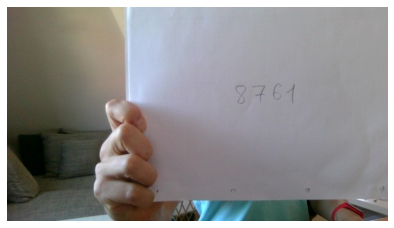

In [20]:
#Get some test images
test_images = Image_generator.load_from_folder("../../Data/4dig/test")
test_image = test_images[1]
test_image_1 = test_images[1]
test_image_2 = test_images[3]
Debug.show_images_list([test_image[:,:,[2,1,0]]],col_number = 2, height=7)

Out shape (256, 256, 1)
out max 255  min 0  mean 130.1849855324074


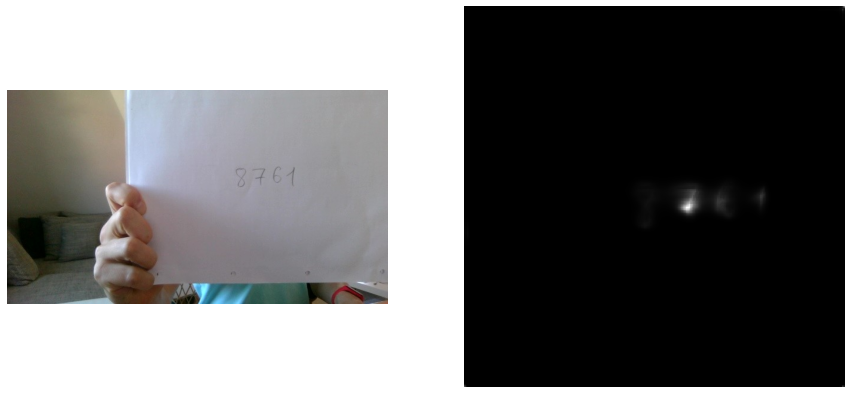

In [34]:
######################################FOR UNET TINY DETECTION
out = production(test_image)

if(out[3].data is not None):
    print("Out shape",out[3].data.shape)
    Debug.show_images_list([
        out[0].data[:,:,[2,1,0]],
        out[3].data.reshape(out[3].data.shape[0],out[3].data.shape[1])
    ],
    col_number = 2, height=7)
else:
    print("Nothing detected")
    Debug.show_images_list([
        out[0].data[:,:,[2,1,0]],
    ],
    col_number = 4, height=5)
print("out max",out[0].data.max(), " min",out[0].data.min(), " mean",out[0].data.mean())
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data.reshape(out.data.shape[0],out.data.shape[1])], col_number = 4, height=5)
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data[:,:,[2,1,0]]], col_number = 4, height=5)


In [12]:
######################################FOR EAST detection DETECTION
out = production(test_image_1)

if(out[3].data is not None):
    print("Out shape",out[3].data.shape)
    Debug.show_images_list([
        out[0].data[:,:,[2,1,0]],
        out[1].data[:,:,[2,1,0]],
        out[2].data.reshape(out[2].data.shape[0],out[2].data.shape[1]),
        out[3].data.reshape(out[3].data.shape[0],out[3].data.shape[1])
    ],
    col_number = 2, height=7)
else:
    print("Nothing detected")
    Debug.show_images_list([
        out[0].data[:,:,[2,1,0]],
        out[1].data[:,:,[2,1,0]],
        out[2].data.reshape(out[2].data.shape[0],out[2].data.shape[1]),
        #out[3].data.reshape(out[3].data.shape[0],out[3].data.shape[1])
    ],
    col_number = 2, height=7)
print("out max",out[0].data.max(), " min",out[0].data.min(), " mean",out[0].data.mean())
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data.reshape(out.data.shape[0],out.data.shape[1])], col_number = 4, height=5)
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data[:,:,[2,1,0]]], col_number = 4, height=5)


center_dist_norm.max() 11.42156
center_norm 11.42156
num_id =  None
Out shape (32, 84)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [13]:
production.layer_show_id.id_module.ft_buffer

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8701633 , -0.46854883,  0.86703473, ...,  0.07849076,
        -0.34598112,  0.1653019 ],
       [ 0.8701633 , -0.46854883,  0.86703473, ...,  0.07849076,
        -0.34598112,  0.1653019 ],
       [ 0.8701633 , -0.46854883,  0.86703473, ...,  0.07849076,
        -0.34598112,  0.1653019 ],
       [ 0.8701633 , -0.46854883,  0.86703473, ...,  0.07849076,
        -0.34598112,  0.1653019 ]], dtype=float32)

center_dist_norm.max() 11.421560087950615
center_norm 11.421560087950615
num_id =  None
center_dist_norm.max() 11.421560087950615
center_norm 11.421560087950615
num_id =  None
center_dist_norm.max() 11.429741509149595
center_norm 11.429741509149595
num_id =  None
center_dist_norm.max() 11.466862310043778
center_norm 11.466862310043778
num_id =  None
center_dist_norm.max() 11.43040875978857
center_norm 11.43040875978857
num_id =  None
center_dist_norm.max() 1.466387610867
center_norm 14.27383866882614
num_id =  1
center_dist_norm.max() 1.5633658749092538
center_norm 14.29307240998613
likeness_dist_norm_min 2.7147148
num_id =  1
center_dist_norm.max() 1.6381761050079846
center_norm 14.268062177371387
likeness_dist_norm_min 2.5408542
num_id =  1
center_dist_norm.max() 1.7142724920233487
center_norm 14.273477717426442
likeness_dist_norm_min 2.4463422
num_id =  1
center_dist_norm.max() 1.836596593155544
center_norm 14.271495336414636
likeness_dist_norm_min 2.0983958
num_id =  1
center_dist_

../../featexlib/debug.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, row*height))


center_dist_norm.max() 2.8479776598169426
center_norm 14.32763482106204
likeness_dist_norm_min 13.333419
num_id =  3
center_dist_norm.max() 2.786490410258011
center_norm 14.392993849689837
likeness_dist_norm_min 3.8493621
num_id =  4
center_dist_norm.max() 2.6049575568725936
center_norm 14.085255212467452
likeness_dist_norm_min 1.9740975
num_id =  4
center_dist_norm.max() 2.624495450024678
center_norm 14.16704500962362
likeness_dist_norm_min 2.7265089
num_id =  3
center_dist_norm.max() 6.969069643521614
center_norm 13.495148021130074
num_id =  None
center_dist_norm.max() 5.642280988412102
center_norm 13.006143542664004
num_id =  None
center_dist_norm.max() 6.0513845195843965
center_norm 13.091919163647779
num_id =  None
center_dist_norm.max() 7.617423316755095
center_norm 13.38553024975545
num_id =  None
center_dist_norm.max() 1.7172044401972406
center_norm 13.62114193630442
likeness_dist_norm_min 9.669122
num_id =  5
center_dist_norm.max() 1.577236125313047
center_norm 13.792494264062

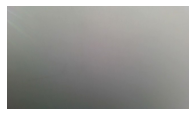

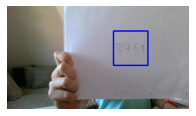

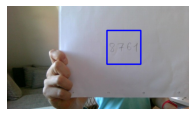

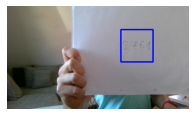

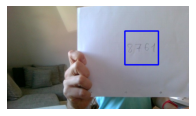

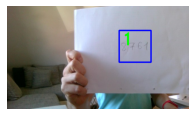

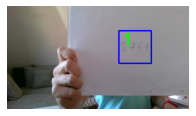

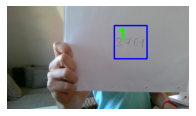

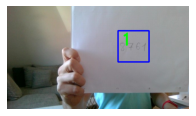

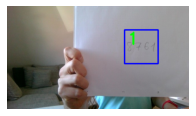

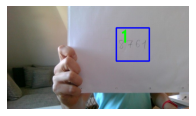

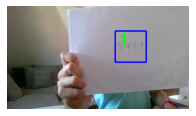

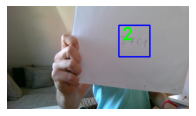

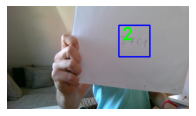

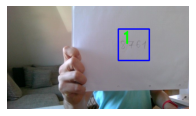

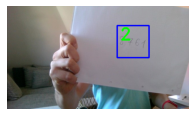

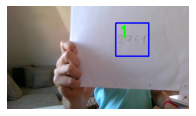

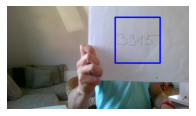

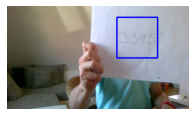

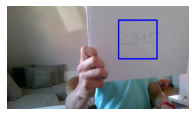

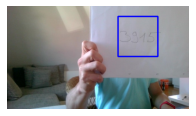

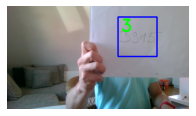

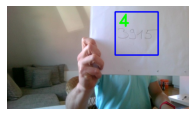

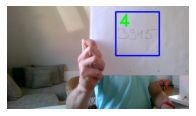

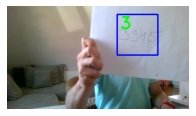

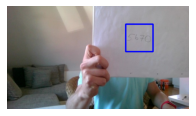

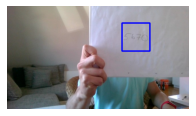

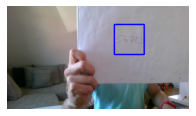

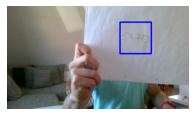

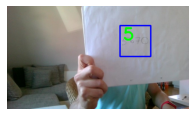

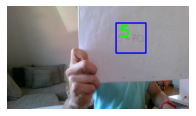

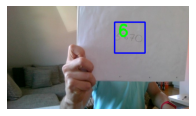

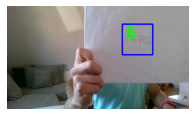

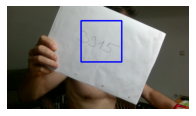

In [15]:
#############All folder test
test_images = Image_generator.load_from_folder("../../Data/4dig/test")
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]]], col_number = 4, height=2)

for i in test_images:
    out = production(i)
    Debug.show_images_list([out[0].data[:,:,[2,1,0]]], col_number = 4, height=2)

In [82]:
feat.id_list

array([[ 1,  1,  2,  1,  1],
       [-1, -1, -2, -1, -1],
       [ 1,  1,  2,  1,  1]])

In [50]:
feat = np.array([-1,-1,-2,-1,1])

vector_list = np.array([
    [1,1,2,1,1],
    [-1,-1,-2,-1,-1],
    [0,0,0,1,1]
])



if vector_list.size > 0:
    close_vector_indice = np.linalg.norm(vector_list - feat, axis=1).argmin()
    print(vector_list[close_vector_indice])
    
np.linalg.norm(np.array([1,1,2,1,1]))

[-1 -1 -2 -1 -1]


2.8284271247461903

In [21]:
vector_list = np.vstack([vector_list,feat])


In [22]:
vector_list

array([[ 1,  1,  2,  1,  1],
       [-1, -1, -2, -1, -1],
       [ 0,  0,  0,  1,  1],
       [ 1,  1,  2,  1,  1]])